#Autoencoder model

In this colab we have tried to generate new images by training an autoencoder and then removing the encoder and leave the decoder

##Importing libraries and dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 17.0 MB/s 


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.decomposition import PCA

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
!unzip -q /gdrive/MyDrive/ANNDL/Homework2/training_dataset_homework2.zip

##Inspecting and preprocessing the data

We have used only the class 9 for the testing the usability of the model

{0: 22.852941176470587, 1: 6.317073170731708, 2: 2.8777777777777778, 3: 2.0393700787401574, 4: 12.53225806451613, 5: 5.078431372549019, 6: 2.4824281150159746, 7: 11.426470588235293, 8: 6.475, 9: 1.0, 10: 10.090909090909092, 11: 15.235294117647058}


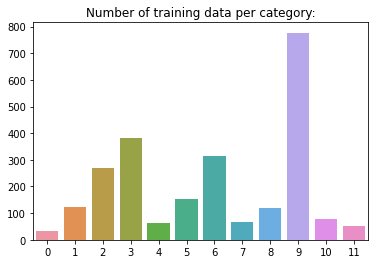

In [7]:
# Data load

x_data = np.load('x_train.npy')
y_data = np.load('y_train.npy')

# Print the array
# print(x_train.shape)
# print(y_train.shape)
# print(x_train[0])
# print(x_train[1])
# print(y_train)
classes = np.zeros(12)
for x in y_data:
  classes[x] +=1


import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=np.arange(12), y=classes).set_title("Number of training data per category:")
weight = max(classes)/classes
class_weight = {}
for i in range(12):
  class_weight[i] = weight[i]
print(class_weight)

In [8]:
x_train = []
y_train = []
for i in range(len(y_data)):
  if(y_data[i]==9):
    x_train.append(x_data[i])
    y_train.append(y_data[i])

In [9]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, random_state=seed, test_size=0.1)

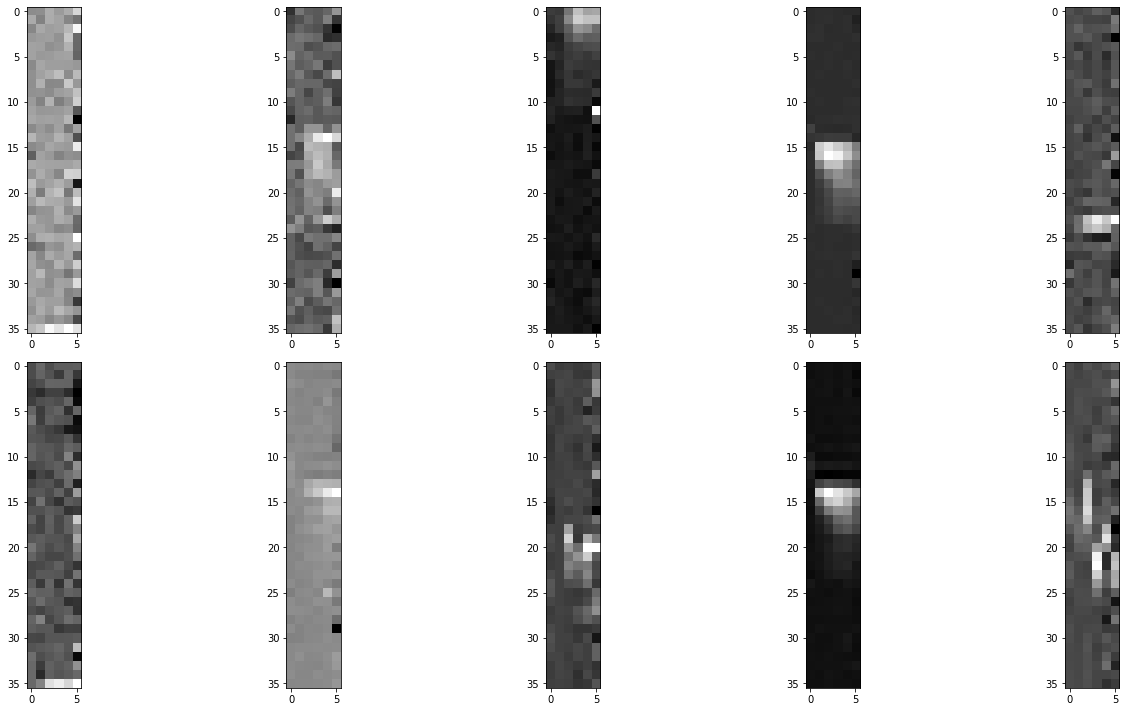

In [10]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.squeeze(X_train[i]), cmap='gray')
plt.tight_layout()
plt.show()

In [11]:
X_train = (np.expand_dims(X_train, axis=-1)/255.).astype(np.float32)
print('Data shape', X_train.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X_train.min(), X_train.max(), X_train.mean(), X_train.std()))

Data shape (699, 36, 6, 1)
Data min -9.68
Data max 79.79
Data mean 0.05
Data std 0.62


In [12]:
X_val = (np.expand_dims(X_val, axis=-1)/255.).astype(np.float32)
print('Data shape', X_val.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X_val.min(), X_val.max(), X_val.mean(), X_val.std()))

Data shape (78, 36, 6, 1)
Data min -3.31
Data max 33.49
Data mean 0.07
Data std 0.61


In [13]:
input_shape = X_train.shape[1:]
input_shape

(36, 6, 1)

In [14]:
latent_dim = 32

## Building the Autoencoder model 


In [16]:
def get_encoder(enc_input_shape=input_shape, enc_output_shape=latent_dim, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=enc_input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2))(input_layer)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Flatten()(x)
    output_layer = tfkl.Dense(enc_output_shape, name='output_layer')(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='encoder')

    return model

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 36, 6, 1)]        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 40, 10, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 5, 64)         640       
                                                                 
 batch_normalization_3 (Batc  (None, 20, 5, 64)        256       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 20, 5, 64)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 3, 128)        7385

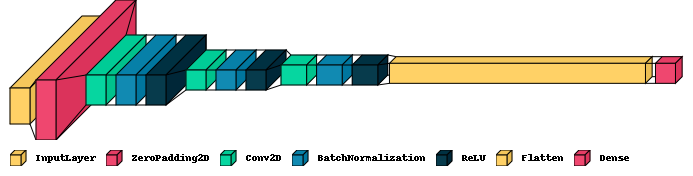

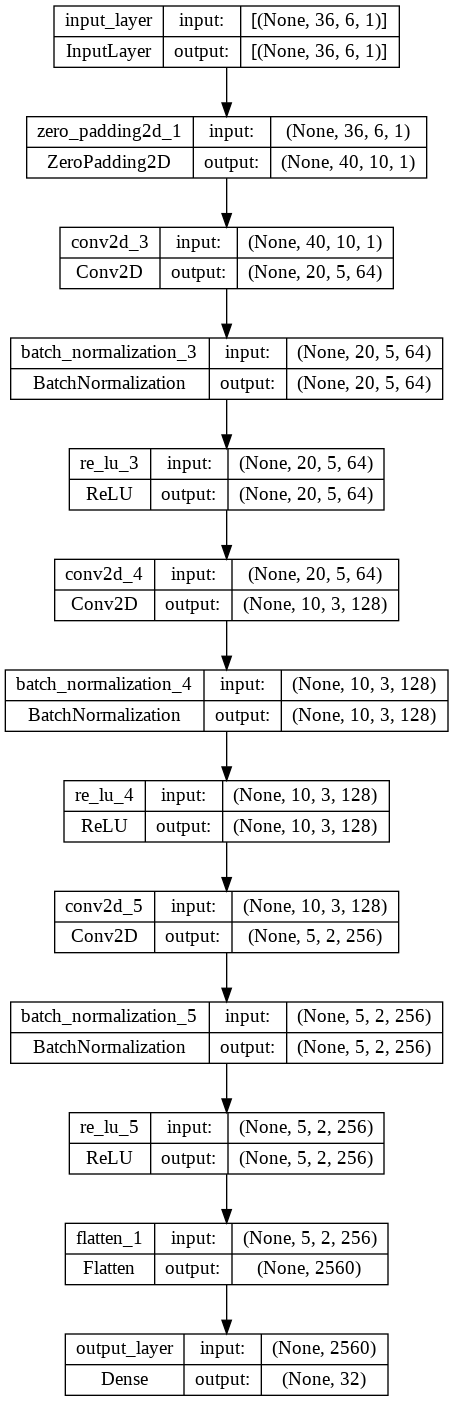

In [17]:
encoder = get_encoder(input_shape)
encoder.summary()
display(visualkeras.layered_view(encoder, legend=True, scale_xy=6))
tfk.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')

In [18]:
def get_decoder(dec_input_shape=latent_dim, dec_output_shape=input_shape, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=dec_input_shape, name='input_layer')
    x = tfkl.Dense(5*2*256)(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Reshape((5,2,256))(x)

    x = tfkl.Conv2DTranspose(128, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2DTranspose(64, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2DTranspose(32, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(dec_output_shape[-1], 3, padding='same')(x)
    x = tfkl.Activation('sigmoid')(x)
    output_layer = tfkl.Cropping2D(((2,2),(5,5)))(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='decoder')

    return model

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 2560)              84480     
                                                                 
 batch_normalization_6 (Batc  (None, 2560)             10240     
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 2560)              0         
                                                                 
 reshape (Reshape)           (None, 5, 2, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 4, 128)       295040    
 nspose)                                                   

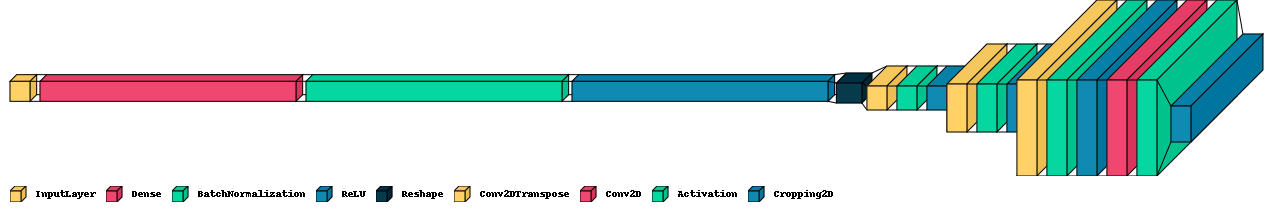

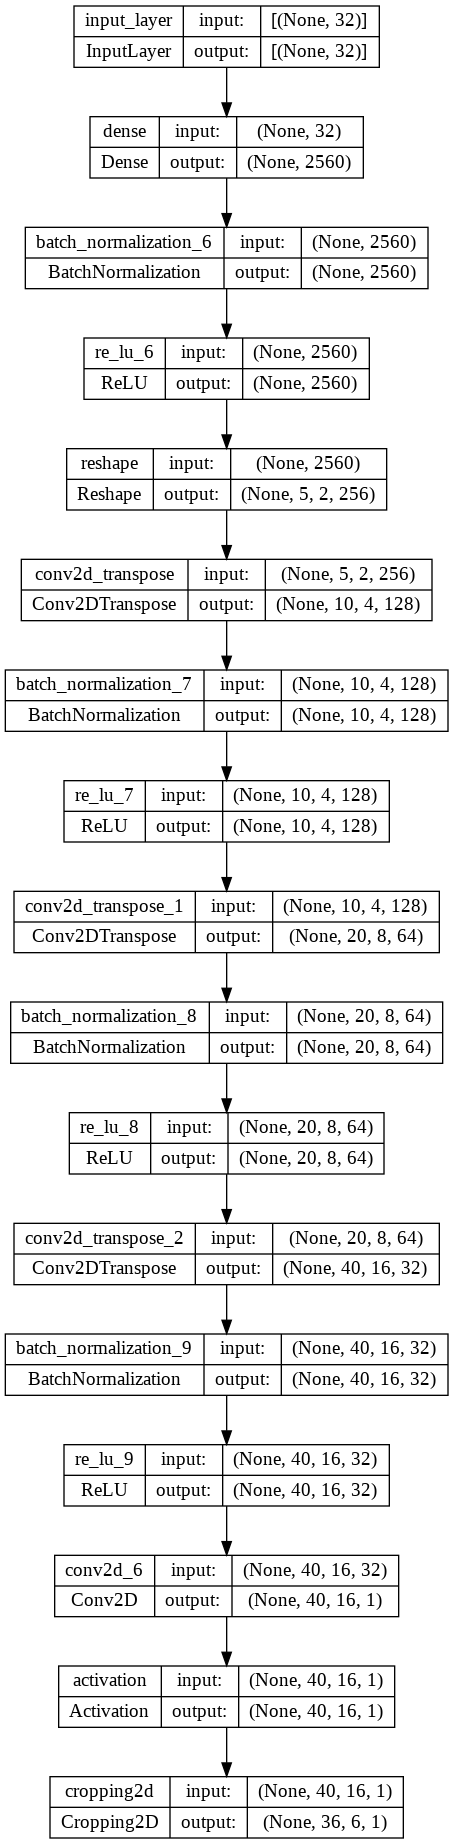

In [19]:
decoder = get_decoder()
decoder.summary()
display(visualkeras.layered_view(decoder, legend=True, scale_xy=6))
tfk.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')

In [20]:
def get_autoencoder(ae_input_shape=input_shape, ae_output_shape=input_shape):
    tf.random.set_seed(seed)
    
    encoder = get_encoder()
    decoder = get_decoder()

    input_layer = tfkl.Input(shape=ae_input_shape)
    z = encoder(input_layer)
    output_layer = decoder(z)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
    return model

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 6, 1)]        0         
                                                                 
 encoder (Functional)        (None, 32)                453408    
                                                                 
 decoder (Functional)        (None, 36, 6, 1)          483201    
                                                                 
Total params: 936,609
Trainable params: 930,145
Non-trainable params: 6,464
_________________________________________________________________


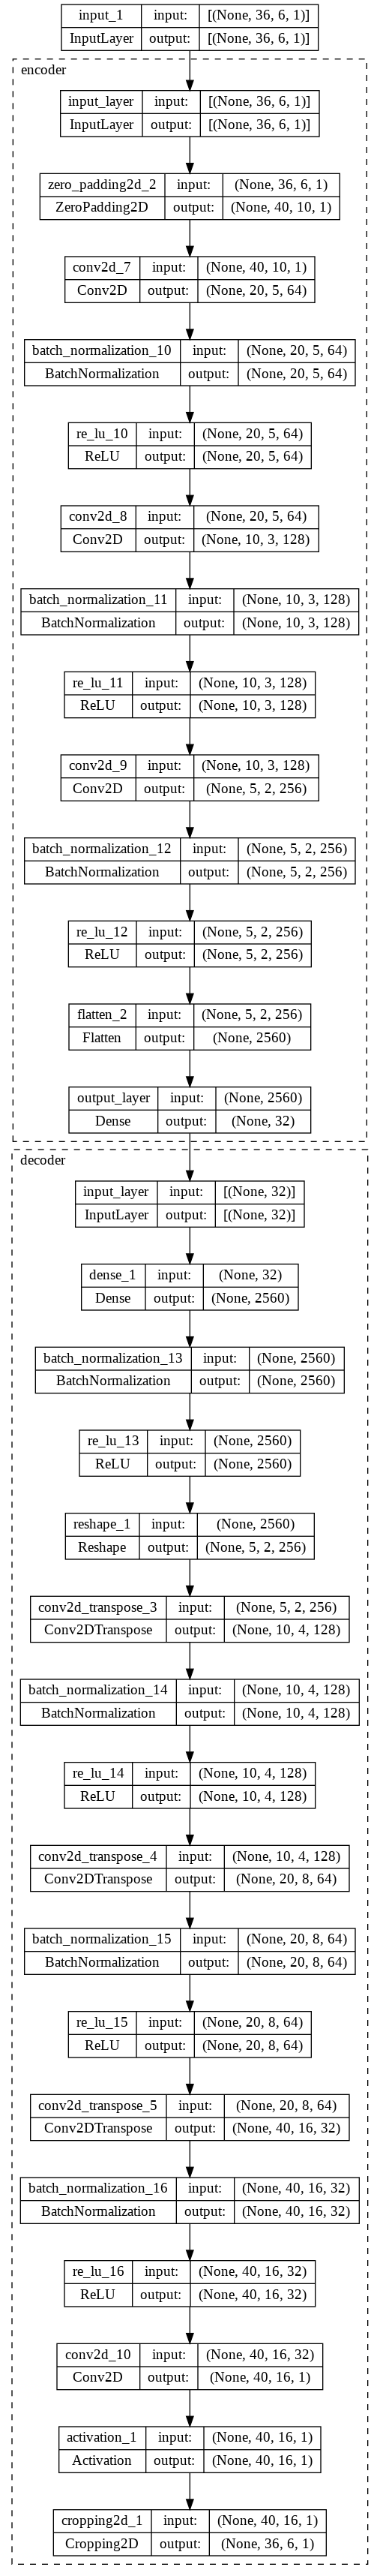

In [21]:
autoencoder = get_autoencoder()
autoencoder.summary()
tfk.utils.plot_model(autoencoder, show_shapes=True, expand_nested=True, to_file='autoencoder.png')

In [22]:
encoder_decoder = tfk.Sequential()
encoder_decoder.add(tfkl.LSTM(36, activation='relu', input_shape=(36, 6), return_sequences=True))
encoder_decoder.add(tfkl.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(tfkl.LSTM(2, activation='relu'))
encoder_decoder.add(tfkl.RepeatVector(36))
encoder_decoder.add(tfkl.LSTM(36, activation='relu', return_sequences=True))
encoder_decoder.add(tfkl.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(tfkl.TimeDistributed(tfkl.Dense(6)))
encoder_decoder.summary()

adam =tf. optimizers.Adam(1e-3)
encoder_decoder.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36, 36)            6192      
                                                                 
 lstm_1 (LSTM)               (None, 36, 6)             1032      
                                                                 
 lstm_2 (LSTM)               (None, 2)                 72        
                                                                 
 repeat_vector (RepeatVector  (None, 36, 2)            0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 36, 36)            5616      
                                                                 
 lstm_4 (LSTM)               (None, 36, 6)             1032      
                                                        

##Fitting the Autoencoder model

In [25]:
learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)
autoencoder.compile(optimizer=optimizer, loss=tfk.losses.binary_crossentropy, metrics=['mse', 'mae'])

batch_size = 128
epochs = 300

In [26]:
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val,X_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=50, factor=0.5, min_lr=1e-5),
    ]
).history

Epoch 1/300
6/6 [==============================] - 8s 189ms/step - loss: 0.4240 - mse: 0.4610 - mae: 0.3217 - val_loss: 0.6733 - val_mse: 0.5521 - val_mae: 0.4960 - lr: 0.0010
Epoch 2/300
6/6 [==============================] - 0s 19ms/step - loss: 0.0968 - mse: 0.3735 - mae: 0.1555 - val_loss: 0.6392 - val_mse: 0.5350 - val_mae: 0.4769 - lr: 0.0010
Epoch 3/300
6/6 [==============================] - 0s 20ms/step - loss: -0.0082 - mse: 0.3559 - mae: 0.0987 - val_loss: 0.5920 - val_mse: 0.5117 - val_mae: 0.4493 - lr: 0.0010
Epoch 4/300
6/6 [==============================] - 0s 20ms/step - loss: -0.0687 - mse: 0.3510 - mae: 0.0779 - val_loss: 0.5407 - val_mse: 0.4866 - val_mae: 0.4186 - lr: 0.0010
Epoch 5/300
6/6 [==============================] - 0s 20ms/step - loss: -0.0831 - mse: 0.3505 - mae: 0.0749 - val_loss: 0.4932 - val_mse: 0.4641 - val_mae: 0.3875 - lr: 0.0010
Epoch 6/300
6/6 [==============================] - 0s 20ms/step - loss: -0.1017 - mse: 0.3476 - mae: 0.0708 - val_loss: 0

##Plotting the results

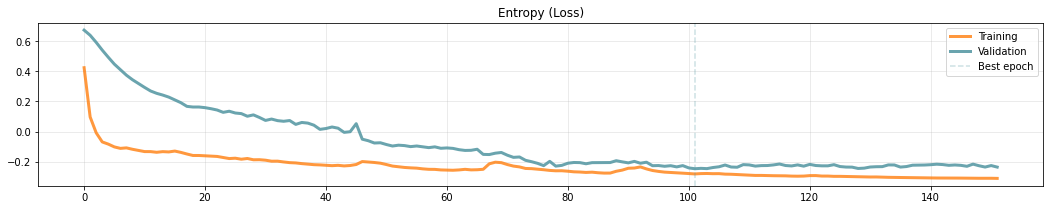

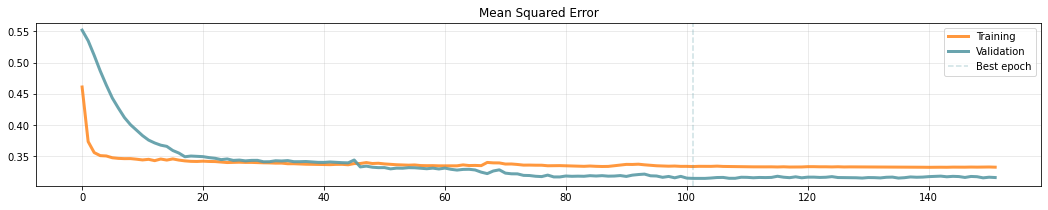

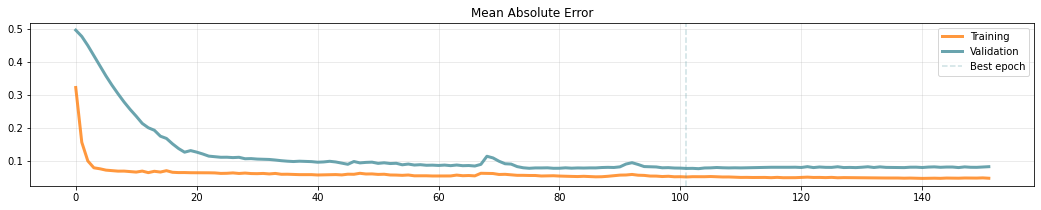

In [28]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mse'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_mse'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mae'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_mae'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()


Save the model if needed

In [ ]:
autoencoder.save('/gdrive/MyDrive/ANNDL/Homework2/models/autoencoder_latent2')

In [33]:
encoder_latent2 = autoencoder.get_layer('encoder')
decoder_latent2 = autoencoder.get_layer('decoder')

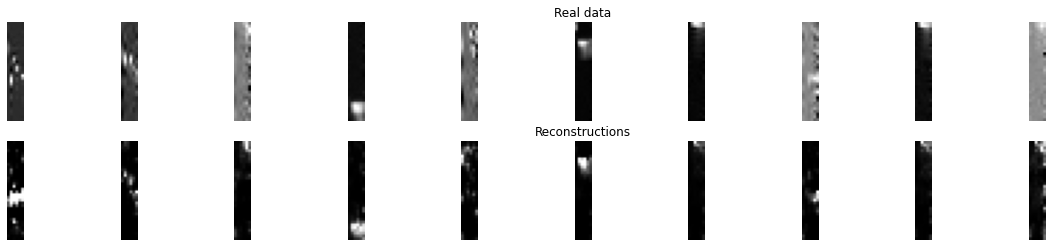

Entropy: -0.24810027
MSE: 0.3145934
MAE: 0.07591747


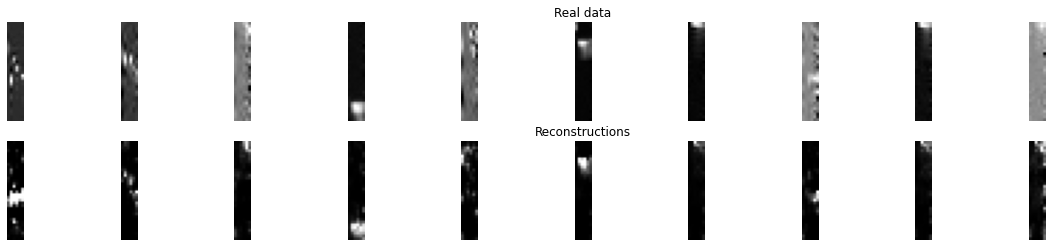

Entropy: -0.24810027
MSE: 0.3145934
MAE: 0.07591747


In [32]:
def get_reconstructions(model, X, imgs=10, verbose=True):
    predictions = model.predict(X, verbose=0)
    fig, axs = plt.subplots(2, imgs, figsize=(imgs*2, 4))
    for i in range(imgs):
        axs[0, i].imshow(np.squeeze(X[i]), cmap=plt.get_cmap('gray'))
        axs.flat[i].axis('off')
        axs[1, i].imshow(np.squeeze(predictions[i]), cmap=plt.get_cmap('gray'))
        axs.flat[i+imgs].axis('off')
    axs[0,imgs//2].set_title('Real data')
    axs[1,imgs//2].set_title('Reconstructions')
    plt.show()
    if verbose:
        entropy_score = np.mean(tfk.losses.binary_crossentropy(X, predictions))
        mse_score = np.mean(tfk.losses.mean_squared_error(X, predictions))
        mae_score = np.mean(tfk.losses.mean_absolute_error(X, predictions))
        print('Entropy:',entropy_score)
        print('MSE:',mse_score)
        print('MAE:',mae_score)

get_reconstructions(autoencoder, X_val)
get_reconstructions(autoencoder, X_val)